In [1]:
%matplotlib inline

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import pickle
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [4]:
SEED = 1
BATCH_SIZE = 128
EPOCHS = 20
NUM_WORKERS = 4
PIN_MEMORY = False
LOG_INTERVAL = 100

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
with open('data/mnist_full.pkl', 'rb') as f:
    mnist_full = pickle.load(f)

In [8]:
x_train = mnist_full["x_train"]
y_train = mnist_full["y_train"]
x_val = mnist_full["x_val"]
y_val = mnist_full["y_val"]
x_test = mnist_full['x_test']
y_test = mnist_full['y_test']

In [9]:
train_dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
val_dataset = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).long())
test_dataset = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [11]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [14]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [15]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/55000 (0%)]	Loss: 550.746948
Train Epoch: 1 [12800/55000 (23%)]	Loss: 182.750534
Train Epoch: 1 [25600/55000 (47%)]	Loss: 151.432098
Train Epoch: 1 [38400/55000 (70%)]	Loss: 138.108337
Train Epoch: 1 [51200/55000 (93%)]	Loss: 131.438995
====> Epoch: 1 Average loss: 168.2009
====> Test set loss: 130.0737
Train Epoch: 2 [0/55000 (0%)]	Loss: 132.847916
Train Epoch: 2 [12800/55000 (23%)]	Loss: 125.364250
Train Epoch: 2 [25600/55000 (47%)]	Loss: 124.322678
Train Epoch: 2 [38400/55000 (70%)]	Loss: 124.047089
Train Epoch: 2 [51200/55000 (93%)]	Loss: 115.778244
====> Epoch: 2 Average loss: 123.3818
====> Test set loss: 117.4071
Train Epoch: 3 [0/55000 (0%)]	Loss: 117.303062
Train Epoch: 3 [12800/55000 (23%)]	Loss: 116.933510
Train Epoch: 3 [25600/55000 (47%)]	Loss: 118.475998
Train Epoch: 3 [38400/55000 (70%)]	Loss: 115.075127
Train Epoch: 3 [51200/55000 (93%)]	Loss: 114.509148
====> Epoch: 3 Average loss: 115.5959
====> Test set loss: 112.5445
Train Epoch: 4 [0/55000 (0%)]	L

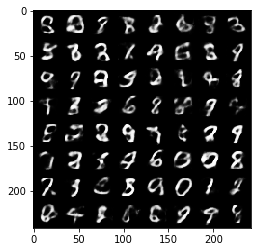

In [16]:
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()
    grid = make_grid(sample.view(64, 1, 28, 28))
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    plt.imshow(ndarr, cmap='gray')
    #save_image(sample.view(64, 1, 28, 28),
    #           'results/sample_' + str(epoch) + '.png')
